In [1]:
import zoopt

In [3]:
from zoopt import Objective, Parameter, ExpOpt
from math import exp

[zoopt] expected remaining running time: 00:00:12
[zoopt] solved solution is:
[zoopt] x: array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0.])
[zoopt] value: [0.5632809741874065, 0.0]


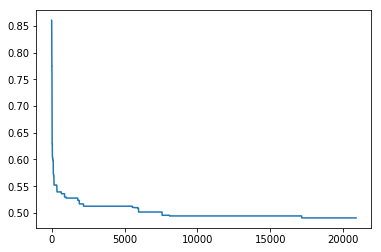

[zoopt] Best 1 result: [0.56328097 0.        ] +- [0. 0.]


In [4]:
# load data file
mse = SparseMSE('sonar.arff')
mse.set_sparsity(8)

# setup objective
# print(mse.get_dim().get_size())
objective = Objective(func=mse.loss, dim=mse.get_dim(), constraint=mse.constraint)
parameter = Parameter(algorithm='poss', budget=2 * exp(1) * (mse.get_sparsity() ** 2) * mse.get_dim().get_size())

# perform sparse regression with constraint |w|_0 <= k
solution_list = ExpOpt.min(objective, parameter, repeat=1, plot=True)

In [3]:
import numpy as np
def ackley(solution):
    x = solution.get_x()
    bias = 0.2
    value = -20 * np.exp(-0.2 * np.sqrt(sum([(i - bias) * (i - bias) for i in x]) / len(x))) - \
            np.exp(sum([np.cos(2.0*np.pi*(i-bias)) for i in x]) / len(x)) + 20.0 + np.e
    return value

In [4]:
from zoopt import Dimension, Objective, Parameter, Opt

dim = 100  # dimension
obj = Objective(ackley, Dimension(dim, [[-1, 1]] * dim, [False] * dim))
# perform optimization
solution = Opt.min(obj, Parameter(budget=100 * dim))
# print result
solution.print_solution()

[zoopt] x: [0.1991791146002233, 0.1771423184651857, 0.1845226004304581, 0.20608987881206509, 0.2322646358817182, 0.20082374625653054, 0.18121641461080218, 0.19410861050123107, 0.20475331818006204, 0.19433411212872387, 0.2161958159227606, 0.18862904654213497, 0.2225443253538939, 0.2069978859200392, 0.19522295983018356, 0.20690825391157097, 0.20840011195111274, 0.19236362894034753, 0.19293526971170083, 0.17305268136176322, 0.21213635865824187, 0.20994491172283425, 0.18494225855618152, 0.16853520598634608, 0.2077491691817115, 0.203434943114996, 0.21648678115736675, 0.1929858753325444, 0.19093971081253236, 0.2039858547164919, 0.2067122101618306, 0.18002901940116356, 0.18532460142064466, 0.20761297352613028, 0.19073730564385372, 0.17315898165526722, 0.18895662670236213, 0.21937422245909755, 0.22081704043554162, 0.18135881818875865, 0.20479159894720556, 0.19955127248594007, 0.2043380944059705, 0.22754845399484114, 0.19626557354938323, 0.17906316559311364, 0.20326843604041533, 0.1913361211647

## Get Data

In [3]:
import sys
import os
import json
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
from datetime import datetime
import pandas as pd
import seaborn as sns

sys.path.append(os.path.abspath('../'))
from data import Data

d = Data()
tracks = d.getTrackFeatures()

In [8]:
tracks = tracks[:, :4]

In [9]:
from sklearn.preprocessing import maxabs_scale
scaledTracks = maxabs_scale(tracks)

In [10]:
scaledTracks

array([[ 0.45983936,  0.591     ,  0.45454545, -0.09368333],
       [ 0.45682731,  0.623     ,  0.72727273, -0.19286667],
       [ 0.74497992,  0.753     ,  0.09090909, -0.09386667],
       ...,
       [ 0.48995984,  0.275     ,  0.18181818, -0.19511667],
       [ 0.62650602,  0.851     ,  0.81818182, -0.0709    ],
       [ 0.55522088,  0.891     ,  0.36363636, -0.03643333]])

In [19]:
scaledTracks = scaledTracks[:100]

### Real Use Case

In [21]:
from random import uniform
from zoopt.dimension import Dimension
from zoopt import Objective, Parameter, ExpOpt

import pdb

class SubsetSelection:
    def __init__(self):
        self.nr_samples = 100
        self.nr_dims = 4
        self.ideal = [0.4, 0.5, 0.4, -0.09]
        self.data = scaledTracks
        #self.data = [[uniform(0.1, 0.4) for _ in range(nr_dims)] for _j in range(nr_samples)]
        self.subsetSize = 10
        
    @property
    def dim(self):
        dim_size = self.nr_samples
        dim_regs = [[0, 1]] * self.nr_samples
        dim_tys = [False] * self.nr_samples
        return Dimension(dim_size, dim_regs, dim_tys)
    
    def evaluate(self, solution):
        x = solution.get_x()
        res = 0
        for i_chosen, chosen in enumerate(x):
            if chosen:
                for dIdx, dValue in enumerate(self.data[i_chosen]):
                    res += abs(self.ideal[dIdx] - dValue)
        return res
    
    def constraint(self, solution):
        x = solution.get_x()
        return sum(x) - self.subsetSize

In [ ]:
def minimize_discrete():
    ss = SubsetSelection()
    
    objective = Objective(ss.evaluate, ss.dim, constraint=ss.constraint)  # form up the objective function

    budget = 1000 * ss.nr_samples  # number of calls to the objective function
    # if autoset is False, you should define train_size, positive_size, negative_size on your own
    parameter = Parameter(algorithm='poss', budget=budget, autoset=True)
    #parameter.set_train_size(6)
    #parameter.set_positive_size(1)
    #parameter.set_negative_size(5)

    return ExpOpt.min(objective, parameter, repeat=1, plot=True)
    
res = minimize_discrete()

[zoopt] expected remaining running time: 00:00:09

In [48]:
res